In [1]:
# !pip install tensorflow_datasets

In [2]:
# 필요한 패키지를 import 합니다.

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
%matplotlib inline

In [3]:
# tensorflow-datasets의 cifar-10 데이터셋을 빌드합니다.
# 데이터 셋을 구성하고 있는 특징과 이미지 특징에 대한 정보를 출력합니다.
cifar100_bldr = tfds.builder('cifar100')

print(cifar100_bldr.info.features)
print('\n', 39 * "=", '\n')
print(cifar100_bldr.info.features['image'])

FeaturesDict({
    'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
})


Image(shape=(32, 32, 3), dtype=tf.uint8)


In [4]:
# 데이터셋 다운로드 및 사용준비를 합니다.
cifar100_bldr.download_and_prepare()

In [5]:
super_label = ['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2']

In [6]:
# train 데이터셋을 로드하여 각 이미지와 라벨을 매핑합니다.
ds_train = cifar100_bldr.as_dataset()['train']

ds_train = ds_train.map(lambda item:
    (item['image'], tf.cast(item['coarse_label'], tf.int32))
)

ds_train = ds_train.batch(18)
images, labels = next(iter(ds_train))

print(images.shape, labels)

(18, 32, 32, 3) tf.Tensor([12 10  5  5  7 11 14 15  9 16  4 19  1 13  0  8  3 16], shape=(18,), dtype=int32)


medium-sized mammals
large natural outdoor scenes
household electrical devices
household electrical devices
insects
large omnivores and herbivores
people
reptiles
large man-made outdoor things
small mammals
fruit and vegetables
vehicles 2
fish
non-insect invertebrates
aquatic mammals
large carnivores
food containers
small mammals


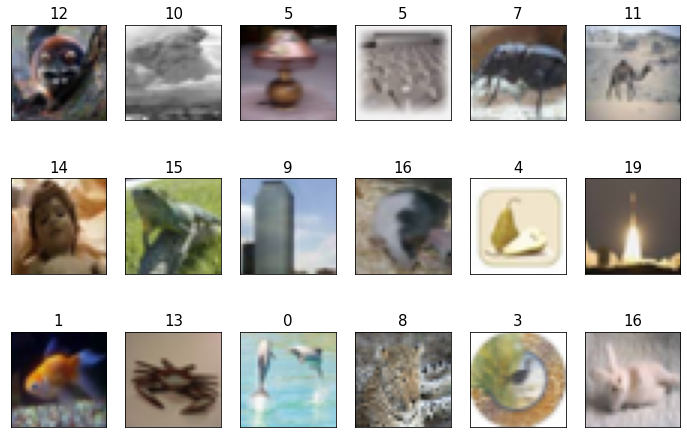

In [7]:
# 학습할 18개의 이미지와 레이블 값을 출력하여 확인합니다.

import math

fig = plt.figure(figsize=(12, 8))
for i, (image, label) in enumerate(zip(images, labels)):
    ax = fig.add_subplot(3, 6, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image)
    ax.set_title('{}'.format(label), size=15)
    print(super_label[label])
plt.show()

In [8]:
cifar100 = cifar100_bldr.as_dataset(shuffle_files=False)

# 학습 데이터와 테스트 데이터로만 이루어져 있기 때문에,
# 학습 데이터중에서 앞에서 45,000개를 학습 데이터로
# 학습 데이터중에서 45,000개 이후부터 50,000까지 검증 데이터셋으로 할당합니다.
cifar100_train = cifar100['train']
cifar100_test = cifar100['test']

cifar100_valid = cifar100_train.take(5000)
cifar100_train = cifar100_train.skip(5000)

print('훈련 데이터셋: {}'.format(len(cifar100_train)))
print('검증 데이터셋: {}'.format(len(cifar100_valid)))
print('테스트 데이터셋: {}'.format(len(cifar100_test)))

훈련 데이터셋: 45000
검증 데이터셋: 5000
테스트 데이터셋: 10000


In [9]:
# train 데이터셋을 로드하여 각 이미지와 라벨을 매핑합니다.

cifar100_train = cifar100_train.map(lambda x:
    (x['image'], tf.cast(x['coarse_label'], tf.int32))
)

train_images, train_labels = next(iter(cifar100_train))

cifar100_valid = cifar100_valid.map(lambda x:
    (x['image'], tf.cast(x['coarse_label'], tf.int32))
)

valid_images, valid_labels = next(iter(cifar100_valid))

In [10]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_images = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_images

In [11]:
train_X = preprocess_image_input(train_images.numpy())
valid_X = preprocess_image_input(valid_images.numpy())

In [12]:
feature_extractor = tf.keras.applications.resnet.ResNet50(
  input_shape=(224, 224, 3),
  include_top = False,
  weights='imagenet'
)

In [13]:
feature_extractor.trainable = False

In [14]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs)
x = feature_extractor(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(20, activation='softmax', name="classification")(x)

In [15]:
model = tf.keras.Model(inputs = inputs, outputs= outputs)

In [16]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800

In [21]:
train_labels.shape

TensorShape([])

In [24]:
history = model.fit(ds_train, epochs=10,
                    validation_data=(valid_X, valid_labels), batch_size=64, shuffle=True)

Epoch 1/10
2778/2778 [==============================] - ETA: 0s - loss: 1.5274 - accuracy: 0.5122

IndexError: ignored